## Version 2 - Boss/client feedback
Oh no, the client has taken a look at our work and they are not happy.  
They spend a lot of money on that data and we have thrown away two whole columns without good reason.  
We need to update our feature engineering to include features based on the cabin and name columns,  
which should also hopefully improve the performance since they feel 74% is a little too low to put into production.  
Also the client doesn't know what to do with a .cbm file, they just want to be able to get new predictions whenever they get new data coming in.  
Let's first implement the new features so that we use the dropped columns and then we can think about getting the predictions to the client somehow.

In [1]:
%pip install cookiecutter-data-science

     -------------------------------------- 102.2/102.2 kB 2.0 MB/s eta 0:00:00
     -------------------------------------- 243.4/243.4 kB 7.3 MB/s eta 0:00:00
     ------------------------------------- 199.4/199.4 kB 11.8 MB/s eta 0:00:00
     ---------------------------------------- 87.5/87.5 kB 5.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Getting the data again.

In [2]:
import os
import zipfile
from pathlib import Path
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# dataset = "student-habits-vs-academic-performance"
# dataset_test = "jayaantanaath/student-habits-vs-academic-performance"
# download_folder = Path("data/student-habits-vs-academic-performance")
# zip_path = download_folder / "student-habits-vs-academic-performance.zip"
# download_folder.mkdir(parents=True, exist_ok=True)

# api.competition_download_files(dataset, path=str(download_folder))
# api.dataset_download_files(dataset_test, path=str(download_folder), unzip=True)

dataset_name = "jayaantanaath/student-habits-vs-academic-performance" #tutaj wpisuje baze
download_folder = Path("data/student-habits-vs-academic-performance") #tutaj bedzie folder w ktorym bedzie dane
download_folder.mkdir(parents=True, exist_ok=True)

api.dataset_download_files(dataset_name, path=str(download_folder), unzip=True)


# with zipfile.ZipFile(zip_path, "r") as zip_ref:
#     zip_ref.extractall(str(download_folder))
# os.remove(zip_path)

Dataset URL: https://www.kaggle.com/datasets/jayaantanaath/student-habits-vs-academic-performance


In [6]:
!dir "./data/student-habits-vs-academic-performance"

 Volume in drive C has no label.
 Volume Serial Number is 67A3-0D30

 Directory of c:\Users\treal\Desktop\Zaliczenie_MLOPS\notebooks\data\student-habits-vs-academic-performance

26.07.2025  22:03    <DIR>          .
26.07.2025  21:42    <DIR>          ..
26.07.2025  22:03            73�663 student_habits_performance.csv
               1 File(s)         73�663 bytes
               2 Dir(s)  42�076�381�184 bytes free


In [42]:
import pandas as pd

df_train = pd.read_csv(download_folder / "student_habits_performance.csv")
df_ids = df_train.pop("student_id")  # set aside student_id

df_train.sample(10)

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
927,20,Female,3.3,4.0,1.9,No,67.1,6.8,Good,0,Bachelor,Good,2,No,43.5
156,23,Male,1.9,3.5,1.7,Yes,71.1,6.3,Fair,0,High School,Good,8,No,57.7
815,21,Female,2.9,2.6,2.0,No,72.7,5.6,Poor,1,Master,Good,1,No,43.5
371,24,Male,0.8,1.4,3.8,Yes,76.5,7.5,Good,2,Bachelor,Average,10,No,36.0
901,20,Male,3.3,2.1,2.1,No,99.4,4.4,Fair,6,High School,Good,3,Yes,71.4
929,17,Female,5.7,2.7,1.4,No,79.0,7.7,Good,0,Master,Average,8,Yes,89.8
290,17,Male,4.0,1.4,1.3,No,80.7,4.8,Fair,2,NaN,Poor,8,No,75.9
344,19,Male,3.2,1.2,1.2,No,78.6,6.6,Fair,2,High School,Poor,10,Yes,81.7
47,23,Female,2.5,2.9,2.7,No,83.5,7.0,Good,4,NaN,Good,8,Yes,59.7
980,20,Female,3.7,3.5,2.5,No,93.0,5.2,Poor,6,High School,Good,10,Yes,81.0


In [43]:
df_train['pass'] = (df_train['exam_score']>70).astype(int)

Quick regex match on the titles

Looks about right:

In [44]:
df_train["gender"].unique()

array(['Female', 'Male', 'Other'], dtype=object)

And for the Cabin we split into deck and cabin number:

Fill remaining nans:

Get indices for categorical columns now including Title and Deck (CabinNumber is numerical):

In [45]:
categorical = [
    "gender", 
    "part_time_job", 
    "diet_quality" ,
    "parental_education_level" ,
    "internet_quality" ,
    "extracurricular_participation" ,
]

y_train = df_train.pop("pass")
X_train = df_train

categorical_indices = [X_train.columns.get_loc(col) for col in categorical if col in X_train.columns]
categorical_indices

[1, 5, 8, 10, 11, 13]

And run the hyperparameter optimization:

In [46]:
import joblib
import optuna
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv

outfolder = Path("..\\results")
outfolder.mkdir(parents=True, exist_ok=True)

best_params_path = outfolder / "best_params.pkl"

if not best_params_path.is_file():
    X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    def objective(trial):
        params = {
            "depth": trial.suggest_int("depth", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3),
            "iterations": trial.suggest_int("iterations", 100, 300),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 100.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.01, 1),
            "random_strength": trial.suggest_float("random_strength", 1e-5, 100.0, log=True)
        }
        model = CatBoostClassifier(**params, verbose=0)
        model.fit(X_train_opt, y_train_opt, eval_set=(X_val_opt, y_val_opt), cat_features=categorical_indices, early_stopping_rounds=50)
        return model.get_best_score()["validation"]["Logloss"]
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)
    
    joblib.dump(study.best_params, best_params_path)
    params = study.best_params
else:
    params = joblib.load(best_params_path)
print("Best Parameters:", params)

Best Parameters: {'depth': 9, 'learning_rate': 0.1989710549297809, 'iterations': 225, 'l2_leaf_reg': 5.203681083589466, 'bagging_temperature': 0.6748870052060675, 'random_strength': 0.27921747675539976}


Do cross validation again:

In [47]:
print(X_train.dtypes)

age                                int64
gender                            object
study_hours_per_day              float64
social_media_hours               float64
netflix_hours                    float64
part_time_job                     object
attendance_percentage            float64
sleep_hours                      float64
diet_quality                      object
exercise_frequency                 int64
parental_education_level          object
internet_quality                  object
mental_health_rating               int64
extracurricular_participation     object
exam_score                       float64
dtype: object


In [48]:
cat_columns = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
print("Kolumny kategoryczne:", cat_columns)

Kolumny kategoryczne: ['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation']


In [53]:
from catboost import Pool, cv

# tylko obiekty tekstowe i kategoryczne
cat_columns = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
X_train[cat_columns] = X_train[cat_columns].astype(str)

# dane do Pool
data = Pool(X_train, y_train, cat_features=cat_columns)

# parametry
params = {
    "eval_metric": "F1",
    "loss_function": "Logloss",
    "iterations": 100,
    "random_seed": 42
}

# cross-validation
cv_results = cv(
    params=params,
    pool=data,
    fold_count=5,
    partition_random_seed=42,
    shuffle=True,
    verbose=False
)

cv_results.to_csv(outfolder / "cv_results_zaliczeniowe_v2.csv", index=False)

Training on fold [0/5]

bestTest = 1
bestIteration = 2

Training on fold [1/5]

bestTest = 1
bestIteration = 1

Training on fold [2/5]

bestTest = 1
bestIteration = 2

Training on fold [3/5]

bestTest = 1
bestIteration = 12

Training on fold [4/5]

bestTest = 1
bestIteration = 0



And get the performance plots:

In [54]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add mean performance line
fig.add_trace(
    go.Scatter(
        x=cv_results["iterations"], y=cv_results["test-F1-mean"], mode="lines", name="Mean F1 Score", line=dict(color="blue")
    )
)

# Add shaded error region
fig.add_trace(
    go.Scatter(
        x=pd.concat([cv_results["iterations"], cv_results["iterations"][::-1]]),
        y=pd.concat([cv_results["test-F1-mean"]+cv_results["test-F1-std"], 
                     cv_results["test-F1-mean"]-cv_results["test-F1-std"]]),
        fill="toself", 
        fillcolor="rgba(0, 0, 255, 0.2)",
        line=dict(color="rgba(255, 255, 255, 0)"),
        showlegend=False
    )
)

# Customize layout
fig.update_layout(
    title="Cross-Validation (N=5) Mean F1 score with Error Bands",
    xaxis_title="Training Steps",
    yaxis_title="Performance Score",
    template="plotly_white",
    yaxis=dict(range=[0.5, 1])
)

fig.write_image(outfolder / "test_f1_v2_zaliczeniowe.png")

In [55]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add mean performance line
fig.add_trace(
    go.Scatter(
        x=cv_results["iterations"], y=cv_results["test-Logloss-mean"], mode="lines", name="Mean logloss", line=dict(color="blue")
    )
)

# Add shaded error region
fig.add_trace(
    go.Scatter(
        x=pd.concat([cv_results["iterations"], cv_results["iterations"][::-1]]),
        y=pd.concat([cv_results["test-Logloss-mean"]+cv_results["test-Logloss-std"], 
                     cv_results["test-Logloss-mean"]-cv_results["test-Logloss-std"]]),
        fill="toself", 
        fillcolor="rgba(0, 0, 255, 0.2)",
        line=dict(color="rgba(255, 255, 255, 0)"),
        showlegend=False
    )
)

# Customize layout
fig.update_layout(
    title="Cross-Validation (N=5) Mean Logloss with Error Bands",
    xaxis_title="Training Steps",
    yaxis_title="Logloss",
    template="plotly_white"
)

#fig.show()

fig.write_image(outfolder / "test_logloss_v2_zaliczeniowe.png")

Fit model on full dataset:

In [86]:
model.fit(
    X_train,
    y_train,
    verbose_eval=50,
    early_stopping_rounds=50,
    cat_features=categorical_indices,
    use_best_model=False,
    plot=True
)

model.save_model(outfolder / 'catboost_model_student_habits_zaliczeniowe.cbm')
joblib.dump(params, outfolder / 'model_params_v2_zaliczeniowe.pkl')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.010302
0:	learn: 0.6686712	total: 19.6ms	remaining: 19.6s
50:	learn: 0.1057615	total: 777ms	remaining: 14.5s
100:	learn: 0.0250611	total: 1.53s	remaining: 13.7s
150:	learn: 0.0100173	total: 2.38s	remaining: 13.4s
200:	learn: 0.0054281	total: 3.27s	remaining: 13s
250:	learn: 0.0036479	total: 4.18s	remaining: 12.5s
300:	learn: 0.0026483	total: 5.06s	remaining: 11.8s
350:	learn: 0.0020502	total: 6s	remaining: 11.1s
400:	learn: 0.0016749	total: 6.91s	remaining: 10.3s
450:	learn: 0.0014343	total: 7.83s	remaining: 9.53s
500:	learn: 0.0012821	total: 8.65s	remaining: 8.62s
550:	learn: 0.0011239	total: 9.58s	remaining: 7.8s
600:	learn: 0.0010147	total: 10.4s	remaining: 6.89s
650:	learn: 0.0009202	total: 11.2s	remaining: 6.03s
700:	learn: 0.0008699	total: 12.1s	remaining: 5.18s
750:	learn: 0.0008245	total: 13.1s	remaining: 4.33s
800:	learn: 0.0007978	total: 14s	remaining: 3.47s
850:	learn: 0.0007762	total: 14.9s	remaining: 2.61s
900:	learn: 0.0007725	total: 15.8s	remaining

['..\\results\\model_params_v2_zaliczeniowe.pkl']

And now to copy paste the train preprocessing code to preprocess the test set, and run a prediction:

In [95]:
from pathlib import Path
import pandas as pd
import re
from catboost import CatBoostClassifier

from catboost import Pool

# Utworzenie Poola z informacją o cechach kategorycznych
test_pool = Pool(data=df_test, cat_features=cat_cols)

# Wczytanie danych testowych
df_test = pd.read_csv("c:/users/treal/desktop/Zaliczenie_MLOPS/notebooks/data/student_habits_test_25.csv")

# Wydzielenie identyfikatora (jeśli 'gender' pełni taką rolę)
df_test_id = df_test.pop("gender")

# Uzupełnienie braków (na podstawie X_train)
df_test = df_test.fillna({
    "Embarked": "N",
    "age": X_train["age"].mean()  # jeśli kolumna 'age' nadal istnieje
})

# Usuń zbędne kolumny (jeśli są nadal obecne)
for col in ["gender", "age"]:
    if col in df_test.columns:
        df_test.drop(columns=[col], inplace=True)

# Uzupełnienie brakujących kolumn względem X_train
missing_cols = set(X_train.columns) - set(df_test.columns)
for col in missing_cols:
    df_test[col] = 0

# Dopasowanie kolejności kolumn
df_test = df_test[X_train.columns]

# Wymuszenie typów string dla cech kategorycznych
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
df_test[cat_cols] = df_test[cat_cols].astype(str)

# Wczytanie modelu
model = CatBoostClassifier()
model.load_model("c:/users/treal/desktop/Zaliczenie_MLOPS/results/catboost_model_students_habits_performance_zaliczeniowe.cbm")

# Predykcja
preds = model.predict(test_pool)


# Zapis wyników
output = pd.DataFrame({
    "student_id": df_test_id,
    "prediction": preds.ravel()
})
output.to_csv("predictions_zaliczenie.csv", index=False)


In [99]:
from catboost import Pool

cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
test_pool = Pool(data=df_test[X_train.columns], cat_features=cat_cols)
preds = model.predict(test_pool)


Get the shapley overview plot showing the importance of the new features as well:

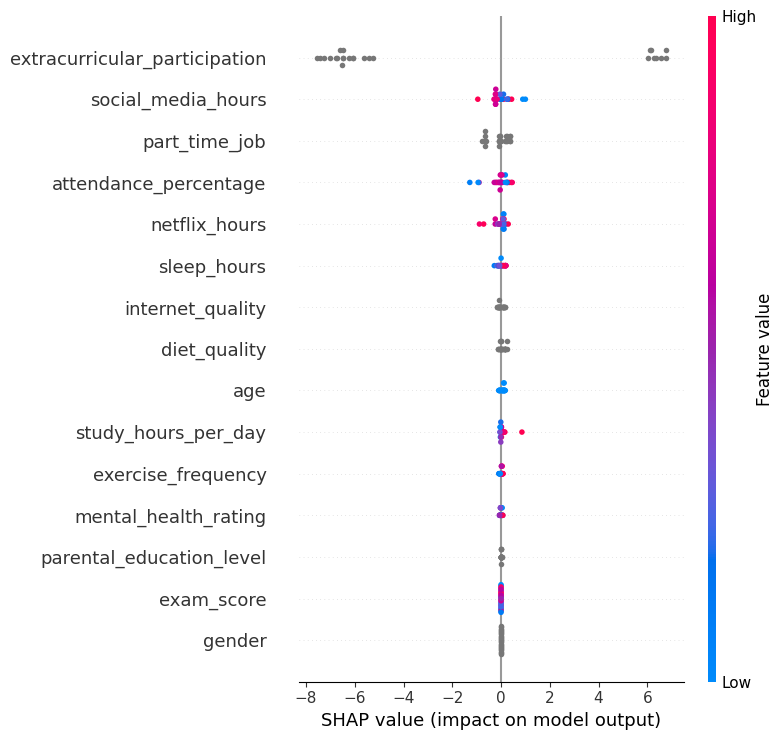

In [101]:
import shap
import matplotlib.pyplot as plt
from catboost import Pool

# Lista cech kategorycznych
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

# Pool do predykcji SHAP
test_pool = Pool(df_test[X_train.columns], cat_features=cat_cols)

# SHAP TreeExplainer i wartości
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_pool)

# Wykres
shap.summary_plot(shap_values, df_test[X_train.columns], show=False)
plt.savefig(outfolder / "test_shap_overall_v2_zaliczeniowe.png")


And finally let's get the score on the test set:

In [103]:
df_test["Studentid"] = df_test_id
df_test["Pass"] = preds

df_test[["Studentid", "Pass"]].to_csv(outfolder / "predictions_v2_zaliczeniowe.csv", index=False)